# Match-3 Level Analyzer — Notebook Version
Run cells top-to-bottom. Edit CSV_PATH if needed.

In [15]:
# Import thư viện 'drive' từ gói 'google.colab'
# Đây là thư viện tích hợp của Google Colab cho phép kết nối với Google Drive
from google.colab import drive

# Mount (kết nối) Google Drive vào môi trường Colab tại thư mục '/content/drive'
# Sau khi mount, bạn có thể truy cập các file/folder trong Drive giống như trên máy tính
# Ví dụ: /content/drive/MyDrive/... sẽ là thư mục gốc của My Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Import các thư viện tiêu chuẩn cần thiết
import csv      # Xử lý đọc/ghi file CSV
import sys      # Làm việc với các tham số, cấu hình hệ thống (nếu cần)
import math     # Các hàm toán học (ceil, floor, sqrt, v.v.)
import random   # Sinh số ngẫu nhiên
import os       # Xử lý đường dẫn và thao tác với hệ thống file/thư mục

# Thử import thư viện matplotlib để vẽ biểu đồ
try:
    import matplotlib.pyplot as plt  # Thư viện vẽ biểu đồ 2D phổ biến
    MATPLOTLIB_OK = True             # Đặt cờ = True nếu import thành công
except Exception:
    MATPLOTLIB_OK = False            # Nếu import lỗi, đặt cờ = False (bỏ qua vẽ biểu đồ)

# Tạo một đối tượng Random với seed = 42 để đảm bảo kết quả sinh ngẫu nhiên có thể tái lập
RNG = random.Random(42)

# Đường dẫn tới file CSV chứa dữ liệu level của game
# Ở đây lưu trong Google Drive: thư mục "Colab Notebooks" -> file "levels_template.csv"
CSV_PATH = r"/content/drive/MyDrive/Colab Notebooks/levels_template.csv"

In [32]:
def parse_grid(grid_text, rows, cols):
    """
    Chuyển đổi chuỗi mô tả Grid thành ma trận 2D (list of lists)
    và kiểm tra kích thước hợp lệ.

    Tham số:
        grid_text (str): Nội dung grid, nhiều dòng, mỗi dòng chứa các ký tự/ô cách nhau bằng khoảng trắng.
                         Ví dụ:
                             "A B C
                              B A C
                              C B A"
        rows (int): Số hàng mong muốn của grid.
        cols (int): Số cột mong muốn của grid.

    Trả về:
        grid (list of lists): Ma trận 2D gồm các ký tự (A, B, C...).
    """

    # Tách từng dòng, loại bỏ khoảng trắng đầu/cuối và bỏ qua dòng rỗng
    lines = [ln.strip() for ln in grid_text.strip().splitlines() if ln.strip()]

    grid = []
    for ln in lines:
        # Tách các phần tử trong dòng theo khoảng trắng, bỏ khoảng trắng thừa
        parts = [p.strip() for p in ln.split() if p.strip()]
        grid.append(parts)  # Thêm dòng vào grid

    # Kiểm tra số hàng và số cột có khớp với tham số rows/cols không
    if len(grid) != int(rows) or any(len(r) != int(cols) for r in grid):
        # Nếu không khớp → báo lỗi
        raise ValueError("Grid size mismatch with GridRows/GridCols")

    # Trả về grid 2D đã chuẩn hóa
    return grid

In [33]:
def find_matches(grid):
    """
    Tìm tất cả các ô nằm trong chuỗi >= 3 ô liên tiếp có cùng giá trị
    (theo hàng ngang hoặc hàng dọc) trong grid.

    Tham số:
        grid (list of lists): Ma trận 2D (ví dụ [['A','B','C'], ...])

    Trả về:
        List[Tuple[int,int]]: Danh sách tọa độ (row, col) của các ô được match.
    """

    # R = số hàng, C = số cột
    R, C = len(grid), len(grid[0])

    # Ma trận đánh dấu ô nào được match (ban đầu tất cả = False)
    matched = [[False] * C for _ in range(R)]

    # ------------------------
    # 1. Quét theo chiều ngang
    # ------------------------
    for r in range(R):
        c = 0
        while c < C:
            k = c + 1
            # Di chuyển k sang phải cho tới khi khác màu hoặc hết hàng
            while k < C and grid[r][k] == grid[r][c]:
                k += 1
            # Nếu chuỗi dài >= 3 ô giống nhau → đánh dấu match
            if k - c >= 3:
                for x in range(c, k):
                    matched[r][x] = True
            # Nhảy c sang vị trí tiếp theo chưa xét
            c = k

    # ------------------------
    # 2. Quét theo chiều dọc
    # ------------------------
    for c in range(C):
        r = 0
        while r < R:
            k = r + 1
            # Di chuyển k xuống dưới cho tới khi khác màu hoặc hết cột
            while k < R and grid[k][c] == grid[r][c]:
                k += 1
            # Nếu chuỗi dài >= 3 ô giống nhau → đánh dấu match
            if k - r >= 3:
                for x in range(r, k):
                    matched[x][c] = True
            # Nhảy r sang vị trí tiếp theo chưa xét
            r = k

    # ------------------------
    # 3. Trả về danh sách tọa độ ô match
    # ------------------------
    return [(r, c) for r in range(R) for c in range(C) if matched[r][c]]

In [34]:
def apply_gravity_and_refill(grid, alphabet):
    """
    Xóa các ô đã match, cho các ô bên trên rơi xuống (gravity),
    và refill các ô trống bằng ký tự mới từ alphabet.

    Tham số:
        grid (list of lists): Ma trận 2D của game (ví dụ [['A','B','C'], ...])
        alphabet (list[str]): Danh sách ký tự khối hợp lệ (ví dụ ['A','B','C','D'])

    Trả về:
        cleared (int): Tổng số ô đã bị xóa trong lượt này.
    """

    # Lấy số hàng (R) và số cột (C)
    R, C = len(grid), len(grid[0])

    # Biến đếm số ô bị clear
    cleared = 0

    # 1. Tìm tất cả ô match
    matched = find_matches(grid)

    # Nếu không có ô match → trả về 0 (không thay đổi grid)
    if not matched:
        return 0

    # 2. Xóa ô match (gán None) và đếm số lượng
    for r, c in matched:
        grid[r][c] = None
        cleared += 1

    # 3. Gravity (kéo ô xuống)
    for c in range(C):                # duyệt từng cột
        write_r = R - 1                # vị trí hàng "đang ghi" (bắt đầu từ đáy)
        # Duyệt từ dưới lên
        for r in range(R - 1, -1, -1):
            if grid[r][c] is not None: # nếu ô hiện tại có giá trị
                grid[write_r][c] = grid[r][c]  # đưa xuống vị trí write_r
                write_r -= 1

        # 4. Refill: Tạo ô mới từ alphabet ở các hàng còn trống (phía trên)
        for r in range(write_r, -1, -1):
            grid[r][c] = random.choice(alphabet)

    # 5. Trả về số ô đã bị xóa
    return cleared

In [35]:
def all_adjacent_swaps(grid):
    """
    Tạo danh sách tất cả các cặp ô liền kề (theo hàng ngang hoặc dọc)
    mà người chơi có thể hoán đổi.

    Tham số:
        grid (list of lists): Ma trận 2D của game.

    Trả về:
        moves (list[tuple]): Danh sách các cặp tọa độ ((r1, c1), (r2, c2)).
    """
    R, C = len(grid), len(grid[0])
    moves = []

    for r in range(R):
        for c in range(C):
            # Nếu chưa ở cuối hàng → có thể swap với ô bên phải
            if c + 1 < C:
                moves.append(((r, c), (r, c + 1)))

            # Nếu chưa ở cuối cột → có thể swap với ô bên dưới
            if r + 1 < R:
                moves.append(((r, c), (r + 1, c)))

    return moves


def swap(g, a, b):
    """
    Hoán đổi giá trị giữa 2 ô trong grid.

    Tham số:
        g (list of lists): Ma trận 2D của game.
        a (tuple): Tọa độ ô thứ nhất (r1, c1).
        b (tuple): Tọa độ ô thứ hai (r2, c2).
    """
    (r1, c1), (r2, c2) = a, b
    g[r1][c1], g[r2][c2] = g[r2][c2], g[r1][c1]


def clone_grid(g):
    """
    Tạo một bản sao độc lập của grid.

    Lưu ý:
        - Sử dụng list comprehension và slicing row[:] để copy từng hàng.
        - Tránh việc copy tham chiếu, giúp các thay đổi ở bản sao
          không ảnh hưởng tới bản gốc.

    Tham số:
        g (list of lists): Ma trận 2D cần sao chép.

    Trả về:
        grid_copy (list of lists): Bản sao của grid.
    """
    return [row[:] for row in g]

In [36]:
def simulate_one_move(grid, alphabet, max_cascades=5):
    """
    Mô phỏng 1 lượt chơi (1 lần swap) theo chiến lược greedy:
    - Thử tất cả các nước đi hợp lệ (adjacent swaps).
    - Chọn nước đi nào clear được nhiều ô nhất (bao gồm hiệu ứng chain/cascade).

    Tham số:
        grid (list of lists): Ma trận 2D hiện tại.
        alphabet (list[str]): Danh sách các ký tự block hợp lệ (A, B, C...).
        max_cascades (int): Số lần chain reaction tối đa (match liên tiếp).

    Trả về:
        best_grid (list of lists): Grid sau khi thực hiện nước đi tốt nhất.
        best_score (int): Số ô bị xóa nhiều nhất trong nước đi đó.
        best_move (tuple): Cặp tọa độ ô được hoán đổi.
    """

    # Sao chép grid ban đầu để không thay đổi bản gốc
    g = clone_grid(grid)

    # Biến lưu kết quả tốt nhất
    best_score = 0
    best_move = None
    best_grid = None

    # Duyệt tất cả nước đi hợp lệ
    for a, b in all_adjacent_swaps(g):
        # Sao chép grid để thử nghiệm nước đi
        gg = clone_grid(g)

        # Thực hiện swap
        swap(gg, a, b)

        # Đếm tổng số ô clear được sau tất cả cascades
        total_cleared = 0

        # Mô phỏng hiệu ứng cascade (ô rơi xuống tạo match mới)
        for _ in range(max_cascades):
            cleared = apply_gravity_and_refill(gg, alphabet)
            if cleared == 0:
                break  # Nếu không còn match → dừng cascade
            total_cleared += cleared

        # Nếu nước đi này tốt hơn kết quả trước → lưu lại
        if total_cleared > best_score:
            best_score = total_cleared
            best_move = (a, b)
            best_grid = gg

    # Nếu không tìm được nước đi hợp lệ (không có match nào)
    if best_move is None:
        return grid, 0, None

    # Trả về grid mới, số ô clear được, và nước đi tốt nhất
    return best_grid, best_score, best_move

In [37]:
def greedy_solver(grid, move_limit, alphabet):
    """
    Mô phỏng toàn bộ quá trình chơi 1 level theo chiến lược greedy:
    - Ở mỗi lượt, chọn nước đi tốt nhất (dùng simulate_one_move).
    - Dừng khi hết lượt hoặc không còn nước đi nào có match.

    Tham số:
        grid (list of lists): Ma trận 2D ban đầu của level.
        move_limit (int): Giới hạn số lượt đi.
        alphabet (list[str]): Danh sách ký tự block hợp lệ.

    Trả về:
        dict: {
            "steps_used": số lượt thực sự đã dùng,
            "total_cleared": tổng số ô bị xóa,
            "efficiency": tỉ lệ ô bị xóa / tổng số ô,
            "final_grid": trạng thái grid sau khi chơi xong
        }
    """

    # Tổng số ô clear được
    total_cleared = 0
    # Số lượt đã sử dụng
    steps = 0
    # Sao chép grid để giữ nguyên bản gốc
    g = clone_grid(grid)

    # Lặp qua từng lượt chơi (tối đa move_limit lượt)
    for _ in range(int(move_limit)):
        # Chọn nước đi tốt nhất và áp dụng
        g, cleared, mv = simulate_one_move(g, alphabet)

        # Nếu không còn nước đi hợp lệ → dừng game
        if mv is None:
            break

        # Cộng dồn số ô đã clear
        total_cleared += cleared
        steps += 1

    # Tính efficiency = % số ô bị xóa so với tổng số ô ban đầu
    R, C = len(grid), len(grid[0])
    efficiency = total_cleared / float(R * C) if R * C > 0 else 0.0

    # Trả về kết quả
    return {
        "steps_used": steps,
        "total_cleared": total_cleared,
        "efficiency": efficiency,
        "final_grid": g
    }

In [38]:
def compute_difficulty(block_types, traps, move_limit, efficiency):
    """
    Tính toán điểm độ khó (Difficulty Score) của một level.

    Công thức được thiết kế dựa theo tín hiệu trong JD (Job Description):
    - Nhiều loại block hơn  → khó hơn.
    - Nhiều bẫy (traps)     → khó hơn.
    - Ít lượt đi (move_limit) → khó hơn.
    - AI efficiency thấp    → level khó hơn cho người chơi.

    Tham số:
        block_types (int): Số loại block khác nhau trong level.
        traps (int): Số lượng bẫy hoặc vật cản.
        move_limit (int): Giới hạn số lượt đi.
        efficiency (float): Tỉ lệ % ô bị AI xóa (0.0 ~ 1.0).

    Trả về:
        float: Điểm độ khó (làm tròn 2 chữ số thập phân).
    """

    # 1. Điểm cơ bản từ block_types và traps
    difficulty = 1.5 * block_types      # mỗi loại block tăng 1.5 điểm
    difficulty += 3.0 * traps           # mỗi trap tăng 3 điểm

    # 2. Giảm độ khó nếu move_limit lớn (nhiều lượt dễ hơn)
    difficulty -= (move_limit / 5.0)    # mỗi 5 lượt giảm 1 điểm

    # 3. Phạt thêm nếu efficiency thấp (AI chơi kém → level khó)
    #    Nếu efficiency = 1.0 → cộng 0 điểm
    #    Nếu efficiency = 0.0 → cộng thêm 5 điểm
    difficulty += (1.0 - max(0.0, min(1.0, efficiency))) * 5.0

    # 4. Làm tròn 2 chữ số thập phân
    return round(difficulty, 2)

In [39]:
def run_on_csv(csv_path):
    """
    Đọc dữ liệu level từ file CSV → mô phỏng chơi → tính toán độ khó → trả về danh sách kết quả.

    Tham số:
        csv_path (str): Đường dẫn file CSV chứa thông tin level.

    Trả về:
        list[dict]: Danh sách kết quả mỗi level (LevelID, Efficiency, DifficultyScore, v.v.)
    """

    # 1. Đọc toàn bộ dữ liệu từ CSV vào list[dict]
    levels = []
    with open(csv_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)  # Đọc từng dòng thành dict (key = tên cột)
        for row in reader:
            levels.append(row)

    results = []  # Danh sách kết quả cho mỗi level

    # 2. Xử lý từng level
    for row in levels:
        level_id = row.get("LevelID", "").strip()
        grid_text = (row.get("Grid", "") or "").strip()

        # Đọc và ép kiểu các thông số số học
        try:
            rows = int(row.get("GridRows", "0") or 0)
            cols = int(row.get("GridCols", "0") or 0)
            move_limit = int(row.get("MoveLimit", "10") or 10)
            block_types = int(row.get("BlockTypes", "3") or 3)
            traps = int(row.get("Traps", "0") or 0)
        except Exception:
            print(f"[WARN] Bad numeric fields at Level {level_id}")
            continue  # Bỏ qua level bị lỗi dữ liệu

        # 3. Tạo bảng chữ cái (A, B, C, ...) dựa trên số lượng block_types
        alphabet = [chr(ord('A') + i) for i in range(max(1, block_types))]

        # 4. Giá trị mặc định nếu không có mô phỏng
        efficiency = 0.0
        steps_used = 0
        total_cleared = 0

        # 5. Nếu có grid → chạy mô phỏng AI chơi level
        if grid_text:
            try:
                # Chuyển grid_text thành ma trận 2D
                grid = parse_grid(grid_text, rows, cols)
                # AI chơi level bằng chiến lược greedy
                sim = greedy_solver(grid, move_limit, alphabet)
                efficiency = sim["efficiency"]
                steps_used = sim["steps_used"]
                total_cleared = sim["total_cleared"]
            except Exception as e:
                print(f"[WARN] Simulation failed at Level {level_id}: {e}")

        # 6. Tính điểm độ khó dựa trên các thông số
        difficulty = compute_difficulty(block_types, traps, move_limit, efficiency)

        # 7. Lưu kết quả vào list
        results.append({
            "LevelID": level_id,
            "Rows": rows,
            "Cols": cols,
            "MoveLimit": move_limit,
            "BlockTypes": block_types,
            "Traps": traps,
            "Efficiency": round(efficiency, 3),
            "StepsUsed": steps_used,
            "TotalCleared": total_cleared,
            "DifficultyScore": difficulty
        })

    return results  # Trả về toàn bộ kết quả


# Gọi hàm và in thử kết quả
results = run_on_csv(CSV_PATH)
print("Levels processed:", len(results))  # Số level đã xử lý
results[:2]  # Xem thử 2 level đầu tiên

Levels processed: 2


[{'LevelID': '1',
  'Rows': 5,
  'Cols': 5,
  'MoveLimit': 15,
  'BlockTypes': 3,
  'Traps': 0,
  'Efficiency': 20.0,
  'StepsUsed': 15,
  'TotalCleared': 500,
  'DifficultyScore': 1.5},
 {'LevelID': '2',
  'Rows': 6,
  'Cols': 6,
  'MoveLimit': 20,
  'BlockTypes': 5,
  'Traps': 1,
  'Efficiency': 0.0,
  'StepsUsed': 0,
  'TotalCleared': 0,
  'DifficultyScore': 11.5}]

In [40]:
import pandas as pd, os
from IPython.display import display  # dùng display của Jupyter/Colab

# Thư mục lưu file
save_dir = r"/content/drive/MyDrive/Colab Notebooks"
os.makedirs(save_dir, exist_ok=True)

# Đường dẫn file CSV
results_path = os.path.join(save_dir, "analysis_results.csv")

if results:
    df = pd.DataFrame(results)
    df.to_csv(results_path, index=False, encoding="utf-8")
    print("Saved:", results_path)
    display(df)          # hiển thị bảng trực tiếp trong notebook
    # Hoặc xem nhanh vài dòng đầu:
    # display(df.head())
else:
    print("No results to save.")


Saved: /content/drive/MyDrive/Colab Notebooks/analysis_results.csv


,LevelID,Rows,Cols,MoveLimit,BlockTypes,Traps,Efficiency,StepsUsed,TotalCleared,DifficultyScore
0,1,5,5,15,3,0,20.0,15,500,1.5
1,2,6,6,20,5,1,0.0,0,0,11.5


Saved chart: /content/drive/MyDrive/Colab Notebooks/difficulty_by_level.png


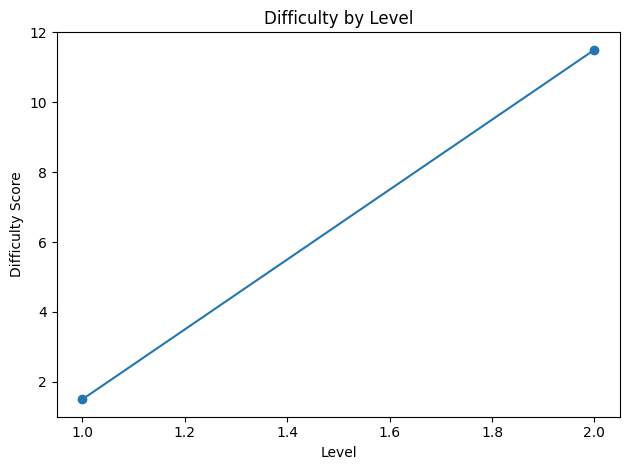

In [30]:
# Chỉ vẽ biểu đồ nếu:
# 1. matplotlib import thành công (MATPLOTLIB_OK = True)
# 2. Có dữ liệu kết quả (results không rỗng)
if MATPLOTLIB_OK and results:
    xs, ys = [], []  # xs = danh sách LevelID, ys = danh sách điểm độ khó

    # Duyệt qua từng kết quả để lấy LevelID (số) và DifficultyScore
    for r in results:
        try:
            xs.append(int(r["LevelID"]))  # Chỉ lấy LevelID dạng số
        except Exception:
            continue  # Bỏ qua nếu LevelID không phải số
        ys.append(r["DifficultyScore"])

    # Chỉ vẽ nếu có ít nhất 1 giá trị hợp lệ
    if xs and ys:
        import matplotlib.pyplot as plt
        plt.figure()

        # Vẽ đường nối các điểm (LevelID, DifficultyScore)
        plt.plot(xs, ys, marker='o')

        # Gắn nhãn trục
        plt.xlabel("Level")
        plt.ylabel("Difficulty Score")

        # Tiêu đề biểu đồ
        plt.title("Difficulty by Level")

        # Căn lề đẹp, tránh chữ bị cắt
        plt.tight_layout()

        # Đường dẫn lưu file PNG vào Google Drive
        png_path = os.path.join(
            r"/content/drive/MyDrive/Colab Notebooks",
            "difficulty_by_level.png"
        )

        # Lưu biểu đồ với độ phân giải 160 DPI
        plt.savefig(png_path, dpi=160)
        print("Saved chart:", png_path)
    else:
        print("No numeric LevelID to plot.")  # Không có LevelID số để vẽ
else:
    print("Plotting skipped (matplotlib unavailable or no results).")